### Part 1: Importing Libraries and Loading Dataset

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Core libraries
import os
import numpy as np
import pandas as pd

# Audio processing
import librosa
import librosa.display
import IPython.display as ipd

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking, Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [2]:
# Emotion mapping
emotion_map = {
    "01":"Neutral",
    "02":"Calm",
    "03":"Happy",
    "04":"Sad",
    "05":"Angry",
    "06":"Fearful",
    "07":"Disgust",
    "08":"Surprised"
}

# Load file paths and metadata
data = []
for root, dirs, files in os.walk("./Speech"):   
    for file in files:
        if file.endswith(".wav"):
            parts = file.split(".")[0].split("-")
            modality, channel, emotion, intensity, statement, repetition, actor = parts
            data.append([
                os.path.join(root, file),
                emotion_map[emotion],
                intensity,
                statement,
                repetition,
                int(actor),
                "male" if int(actor) % 2 else "female"
            ])

ravdess_df = pd.DataFrame(data, columns=[
    "path", "emotion", "intensity", "statement", "repetition", "actor", "gender"
])

print(ravdess_df.head())
print("Total samples:", len(ravdess_df))

                                         path  emotion intensity statement  \
0  ./Speech\Actor_01\03-01-01-01-01-01-01.wav  Neutral        01        01   
1  ./Speech\Actor_01\03-01-01-01-01-02-01.wav  Neutral        01        01   
2  ./Speech\Actor_01\03-01-01-01-02-01-01.wav  Neutral        01        02   
3  ./Speech\Actor_01\03-01-01-01-02-02-01.wav  Neutral        01        02   
4  ./Speech\Actor_01\03-01-02-01-01-01-01.wav     Calm        01        01   

  repetition  actor gender  
0         01      1   male  
1         02      1   male  
2         01      1   male  
3         02      1   male  
4         01      1   male  
Total samples: 2880


### Part 2: Preprocessing

In [3]:
def preprocess_audio(file_path, sr=16000):
    audio, _ = librosa.load(file_path, sr=sr, mono=True)
    audio, _ = librosa.effects.trim(audio)  # Trim silences
    audio = audio / np.max(np.abs(audio))  # Normalize
    return audio

In [4]:
ravdess_df["processed_audio"] = ravdess_df["path"].apply(preprocess_audio)
# Check first audio sample
print(ravdess_df["processed_audio"].iloc[0])
print("Audio length:", len(ravdess_df["processed_audio"].iloc[0]))

[ 7.0836989e-04  1.9017083e-04  4.2543869e-04 ... -7.4292934e-06
  6.3077532e-06 -5.2439532e-06]
Audio length: 34816


### Part 3: Feature Extraction

In [5]:
def extract_features(audio, sr=16000, n_mfcc=13):
    features = {}
    
    # 1. MFCC
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfccs_mean = np.mean(mfccs.T, axis=0)   # take mean across time
    features["mfcc"] = mfccs_mean
    
    # 2. Mel-Spectrogram
    mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_db = librosa.power_to_db(mel, ref=np.max)
    mel_mean = np.mean(mel_db.T, axis=0)
    features["mel"] = mel_mean
    
    # 3. Chroma
    stft = np.abs(librosa.stft(audio))
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    chroma_mean = np.mean(chroma.T, axis=0)
    features["chroma"] = chroma_mean
    
    return features

In [6]:
feature_list = []

for i, row in ravdess_df.iterrows():
    audio = row["processed_audio"]
    feats = extract_features(audio)
    
    # Flatten into one vector (mfcc + mel + chroma)
    combined = np.hstack([feats["mfcc"], feats["mel"], feats["chroma"]])
    
    feature_list.append(combined)

# Convert to numpy array
X = np.array(feature_list)
y = ravdess_df["emotion"].values  # target labels

print("Feature matrix shape:", X.shape)   # (samples, features)
print("Labels shape:", y.shape)

Feature matrix shape: (2880, 153)
Labels shape: (2880,)


In [7]:
print("Feature matrix shape:", X.shape)   # (samples, features)
print("Labels shape:", y.shape)

Feature matrix shape: (2880, 153)
Labels shape: (2880,)


### Part 4: Model Building

In [8]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print("Classes:", label_encoder.classes_)
print("Encoded sample:", y_encoded[:10])
# ML models can't understand text labels so we convert them to numbers

Classes: ['Angry' 'Calm' 'Disgust' 'Fearful' 'Happy' 'Neutral' 'Sad' 'Surprised']
Encoded sample: [5 5 5 5 1 1 1 1 1 1]


In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

In [10]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train_scaled, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

Logistic Regression Accuracy: 0.6111111111111112
              precision    recall  f1-score   support

       Angry       0.74      0.72      0.73        76
        Calm       0.68      0.69      0.68        77
     Disgust       0.60      0.60      0.60        77
     Fearful       0.58      0.56      0.57        77
       Happy       0.55      0.53      0.54        77
     Neutral       0.54      0.58      0.56        38
         Sad       0.51      0.51      0.51        77
   Surprised       0.65      0.69      0.67        77

    accuracy                           0.61       576
   macro avg       0.61      0.61      0.61       576
weighted avg       0.61      0.61      0.61       576



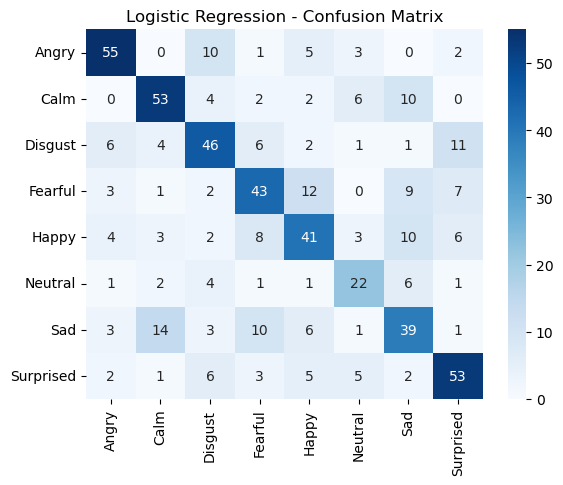

Random Forest Accuracy: 0.1371527777777778
              precision    recall  f1-score   support

       Angry       0.06      0.03      0.04        76
        Calm       0.00      0.00      0.00        77
     Disgust       0.00      0.00      0.00        77
     Fearful       0.14      0.73      0.23        77
       Happy       0.00      0.00      0.00        77
     Neutral       0.00      0.00      0.00        38
         Sad       0.00      0.00      0.00        77
   Surprised       0.16      0.27      0.20        77

    accuracy                           0.14       576
   macro avg       0.04      0.13      0.06       576
weighted avg       0.05      0.14      0.06       576



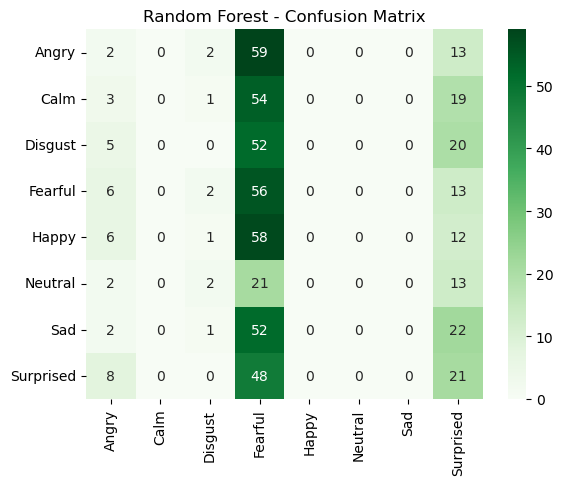

In [13]:
#  Logistic Regression

y_pred_lr = log_reg.predict(X_test_scaled)
acc_lr = accuracy_score(y_test, y_pred_lr)
print("Logistic Regression Accuracy:", acc_lr)
print(classification_report(y_test, y_pred_lr, target_names=label_encoder.classes_))

cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix")
plt.show()


#  Random Forest

y_pred_rf = rf.predict(X_test_scaled)   
acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest Accuracy:", acc_rf)
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Greens")
plt.title("Random Forest - Confusion Matrix")
plt.show()

In [14]:
import numpy as np
unique, counts = np.unique(y_encoded, return_counts=True)

for cls, count in zip(label_encoder.classes_, counts):
    print(f"{cls}: {count}")

Angry: 384
Calm: 384
Disgust: 384
Fearful: 384
Happy: 384
Neutral: 192
Sad: 384
Surprised: 384


### Advanced ML models

In [15]:
# Preparing mel-spectrograms

def get_mel_spectrogram(file_path, sr=16000, n_mels=128, fmax=8000):
    # Load audio
    audio, _ = librosa.load(file_path, sr=sr, mono=True)
    # Trim silence
    audio, _ = librosa.effects.trim(audio)
    # Normalize
    audio = audio / np.max(np.abs(audio))
    # Mel-spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=fmax)
    # Convert to dB
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

In [16]:
# Build dataset for CNN. CNNs expect 3D inputs: (samples, height, width, channels)
import tensorflow as tf

X_cnn = []
for path in ravdess_df["path"]:
    mel = get_mel_spectrogram(path)
    # Resize to fixed shape (e.g., 128x128)
    mel_resized = tf.image.resize(mel[..., np.newaxis], [128, 128]).numpy()
    X_cnn.append(mel_resized)

X_cnn = np.array(X_cnn)
y_cnn = label_encoder.transform(ravdess_df["emotion"])

In [17]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_cnn, y_cnn, test_size=0.2, random_state=42, stratify=y_cnn
)

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = len(label_encoder.classes_)

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    BatchNormalization(),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 63, 63, 32)        128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 30, 30, 64)        0         
 g2D)                                                            
                                                        

In [19]:
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("CNN Test Accuracy:", test_acc)

Epoch 1/30
58/58 [==============================] - 26s 402ms/step - loss: 3.0897 - accuracy: 0.2512 - val_loss: 52.3929 - val_accuracy: 0.0716
Epoch 2/30
58/58 [==============================] - 28s 482ms/step - loss: 1.6833 - accuracy: 0.3869 - val_loss: 19.9848 - val_accuracy: 0.1649
Epoch 3/30
58/58 [==============================] - 25s 438ms/step - loss: 1.4643 - accuracy: 0.4753 - val_loss: 6.8332 - val_accuracy: 0.2017
Epoch 4/30
58/58 [==============================] - 28s 485ms/step - loss: 1.1807 - accuracy: 0.5610 - val_loss: 5.3797 - val_accuracy: 0.1735
Epoch 5/30
58/58 [==============================] - 24s 422ms/step - loss: 0.9478 - accuracy: 0.6576 - val_loss: 1.4872 - val_accuracy: 0.4685
Epoch 6/30
58/58 [==============================] - 23s 401ms/step - loss: 0.7284 - accuracy: 0.7374 - val_loss: 3.4556 - val_accuracy: 0.2885
Epoch 7/30
58/58 [==============================] - 27s 473ms/step - loss: 0.5811 - accuracy: 0.7813 - val_loss: 13.3921 - val_accuracy: 0.2

18/18 [==============================] - 3s 75ms/step
CNN Accuracy: 0.7447916666666666
              precision    recall  f1-score   support

       Angry       0.86      0.83      0.85        76
        Calm       0.67      0.87      0.76        77
     Disgust       0.98      0.56      0.71        77
     Fearful       0.88      0.75      0.81        77
       Happy       0.63      0.74      0.68        77
     Neutral       0.72      0.74      0.73        38
         Sad       0.57      0.87      0.69        77
   Surprised       1.00      0.60      0.75        77

    accuracy                           0.74       576
   macro avg       0.79      0.74      0.75       576
weighted avg       0.79      0.74      0.75       576



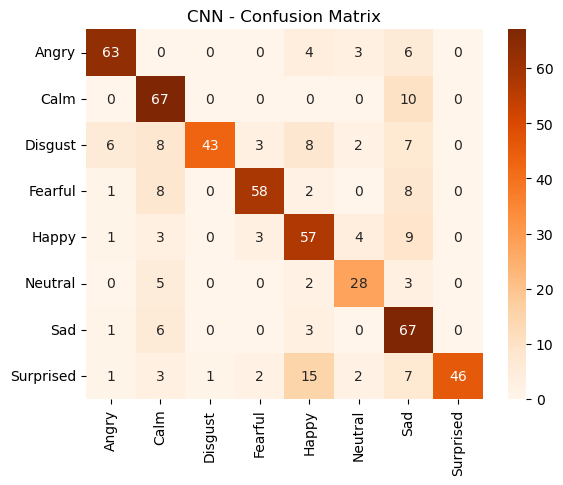

In [20]:
# CNN Evaluation
y_pred_cnn_probs = model.predict(X_test)   
y_pred_cnn = np.argmax(y_pred_cnn_probs, axis=1)

acc_cnn = accuracy_score(y_test, y_pred_cnn)
print("CNN Accuracy:", acc_cnn)
print(classification_report(y_test, y_pred_cnn, target_names=label_encoder.classes_))

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm_cnn, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Oranges")
plt.title("CNN - Confusion Matrix")
plt.show()

In [21]:
def get_mfcc_sequence(file_path, sr=16000, n_mfcc=40, max_len=200):
    # Load audio
    audio, _ = librosa.load(file_path, sr=sr, mono=True)
    # Trim silence
    audio, _ = librosa.effects.trim(audio)
    # Normalize
    audio = audio / np.max(np.abs(audio))
    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    # Transpose: shape -> (time_steps, n_mfcc)
    mfcc = mfcc.T
    # Pad or truncate to max_len
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        mfcc = np.pad(mfcc, ((0,pad_width),(0,0)), mode='constant')
    else:
        mfcc = mfcc[:max_len, :]
    return mfcc

In [22]:
X_rnn = []
for path in ravdess_df["path"]:
    X_rnn.append(get_mfcc_sequence(path))

X_rnn = np.array(X_rnn)  # Shape: (samples, time_steps, n_mfcc)
y_rnn = label_encoder.transform(ravdess_df["emotion"])

In [23]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_rnn, y_rnn, test_size=0.2, random_state=42, stratify=y_rnn
)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Masking

num_classes = len(label_encoder.classes_)

model1 = Sequential([
    Masking(mask_value=0.0, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking (Masking)           (None, 200, 40)           0         
                                                                 
 lstm (LSTM)                 (None, 200, 128)          86528     
                                                                 
 dropout_1 (Dropout)         (None, 200, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 8)                

In [25]:
hist = model1.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32
)

test_loss, test_acc = model1.evaluate(X_test, y_test)
print("RNN Test Accuracy:", test_acc)

Epoch 1/30
58/58 [==============================] - 24s 271ms/step - loss: 1.9777 - accuracy: 0.2257 - val_loss: 1.8419 - val_accuracy: 0.2950
Epoch 2/30
58/58 [==============================] - 13s 217ms/step - loss: 1.6791 - accuracy: 0.3695 - val_loss: 1.7385 - val_accuracy: 0.3341
Epoch 3/30
58/58 [==============================] - 14s 241ms/step - loss: 1.4679 - accuracy: 0.4813 - val_loss: 1.5473 - val_accuracy: 0.4208
Epoch 4/30
58/58 [==============================] - 15s 254ms/step - loss: 1.3094 - accuracy: 0.5345 - val_loss: 1.4151 - val_accuracy: 0.4859
Epoch 5/30
58/58 [==============================] - 16s 269ms/step - loss: 1.1444 - accuracy: 0.5768 - val_loss: 1.1973 - val_accuracy: 0.5597
Epoch 6/30
58/58 [==============================] - 16s 270ms/step - loss: 1.0965 - accuracy: 0.6055 - val_loss: 1.2600 - val_accuracy: 0.5466
Epoch 7/30
58/58 [==============================] - 17s 288ms/step - loss: 0.9051 - accuracy: 0.6782 - val_loss: 1.2087 - val_accuracy: 0.5922

18/18 [==============================] - 4s 69ms/step
RNN (LSTM) Accuracy: 0.8559027777777778
              precision    recall  f1-score   support

       Angry       0.84      0.92      0.88        76
        Calm       0.97      0.92      0.95        77
     Disgust       0.93      0.81      0.86        77
     Fearful       0.89      0.82      0.85        77
       Happy       0.79      0.82      0.80        77
     Neutral       0.81      0.76      0.78        38
         Sad       0.70      0.83      0.76        77
   Surprised       0.96      0.92      0.94        77

    accuracy                           0.86       576
   macro avg       0.86      0.85      0.85       576
weighted avg       0.86      0.86      0.86       576



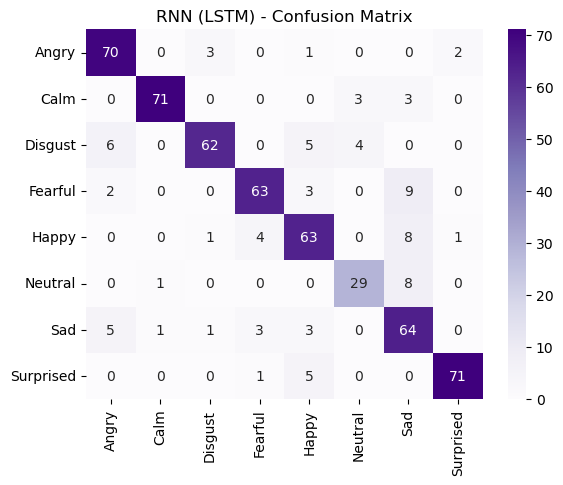

In [26]:
#  LSTM-based RNN

y_pred_rnn_probs = model1.predict(X_test)  
y_pred_rnn = np.argmax(y_pred_rnn_probs, axis=1)
acc_rnn = accuracy_score(y_test, y_pred_rnn)
print("RNN (LSTM) Accuracy:", acc_rnn)
print(classification_report(y_test, y_pred_rnn, target_names=label_encoder.classes_))

cm_rnn = confusion_matrix(y_test, y_pred_rnn)
sns.heatmap(cm_rnn, annot=True, fmt="d", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap="Purples")
plt.title("RNN (LSTM) - Confusion Matrix")
plt.show()

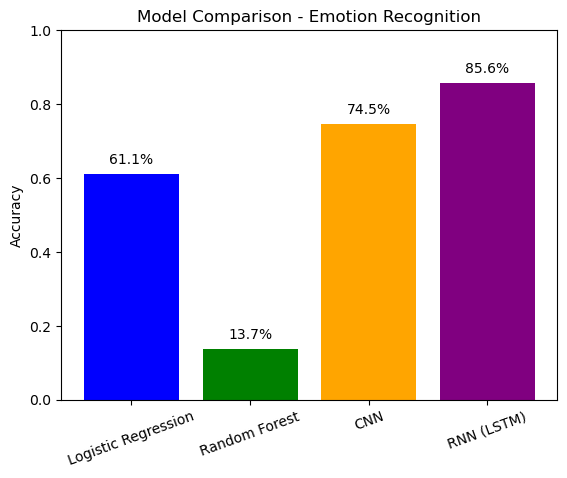

In [32]:
#  Compare All Models

results = {
    "Logistic Regression": acc_lr,
    "Random Forest": acc_rf,
    "CNN": acc_cnn,
    "RNN (LSTM)": acc_rnn
}

bars = plt.bar(results.keys(), results.values(), 
               color=["blue", "green", "orange", "purple"])
plt.ylabel("Accuracy")
plt.title("Model Comparison - Emotion Recognition")
plt.xticks(rotation=20)
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,   # x position
        height + 0.02,                      # y position (slightly above bar)
        f"{height*100:.1f}%",                    # format to 2 decimals
        ha="center", va="bottom", fontsize=10
    )
plt.show()

In [34]:
# # For CNN
# model.save("cnn_emotion_model.h5")

# Save RNN (LSTM) model
model1.save("rnn_emotion_model.h5")
# Save label encoder
import joblib
joblib.dump(label_encoder, "label_encoder.pkl")

['label_encoder.pkl']